In [170]:
# from google.colab import files

# uploaded = files.upload()  # This will prompt a file upload dialog

In [171]:
pip install pandas numpy matplotlib prophet scikit-learn joblib

In [172]:
import pandas as pd
import os

In [173]:
trends_data = pd.read_csv('Feminine WearDataSet.csv')

In [174]:
df=trends_data

In [175]:
trends_data.head()

,release_date,Feminine Wear
0,2021-12-01,0.0
1,2021-12-02,0.0
2,2021-12-03,0.0
3,2021-12-05,0.0
4,2021-12-06,0.0


In [176]:
# Assuming your dataframe is called df
df = df.rename(columns={'release_date': 'ds', 'Feminine Wear': 'y'})

# Convert 'ds' column to datetime
df['ds'] = pd.to_datetime(df['ds'])


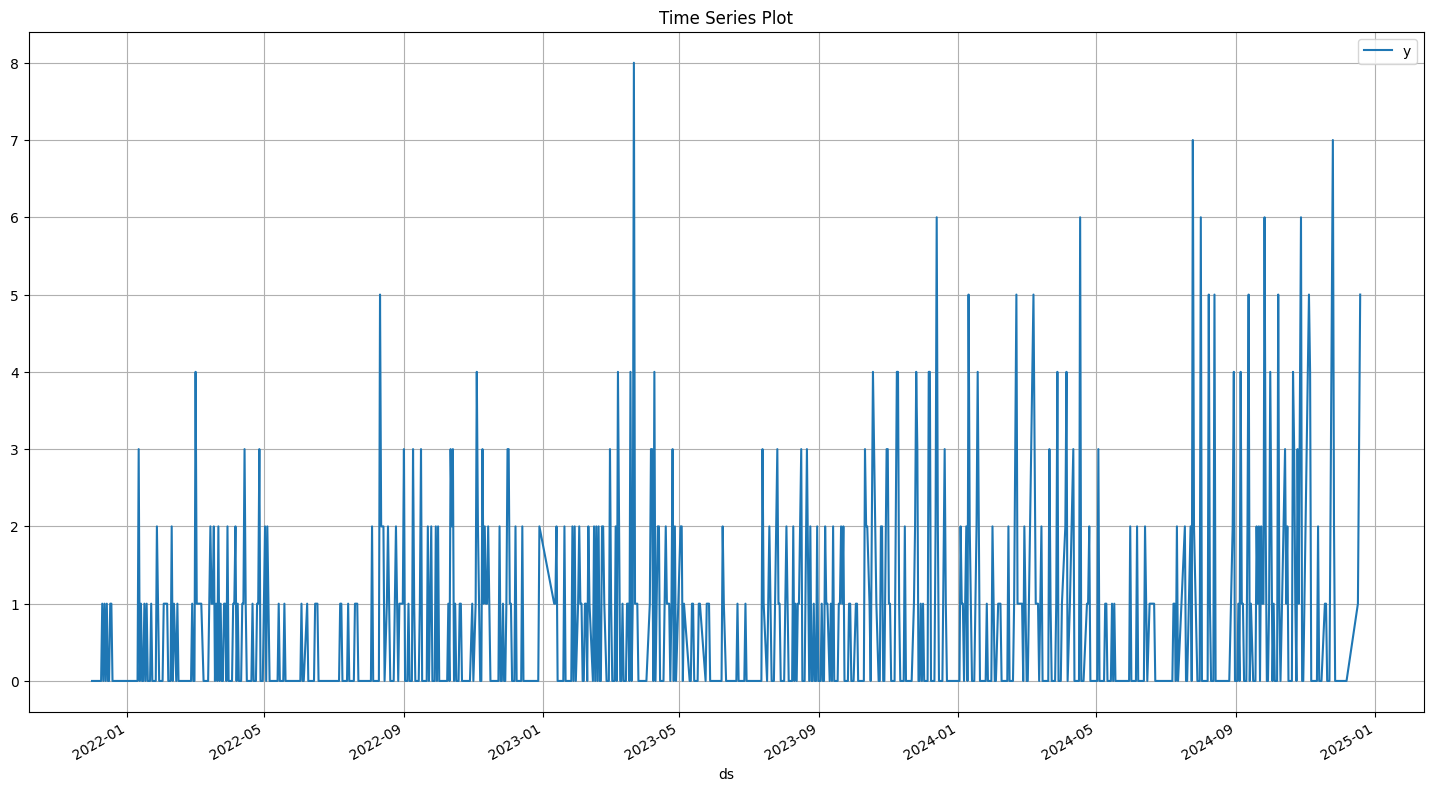

In [177]:
import matplotlib.pyplot as plt

df.plot(x='ds', y='y', title='Time Series Plot', figsize=(18, 10))
plt.grid(True)
plt.show()


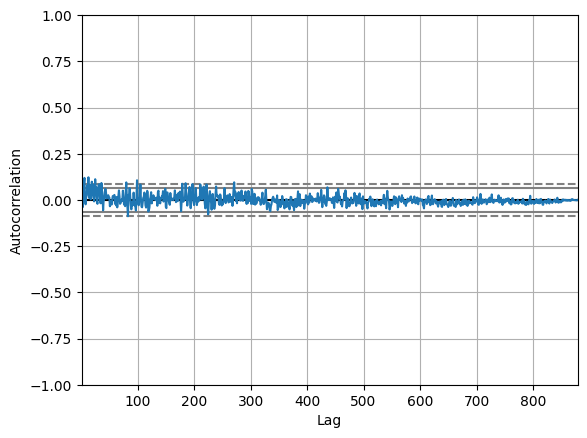

In [178]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['y'])
plt.show()


In [179]:
import numpy as np

# Extract month from the datetime column
df['month'] = df['ds'].dt.month




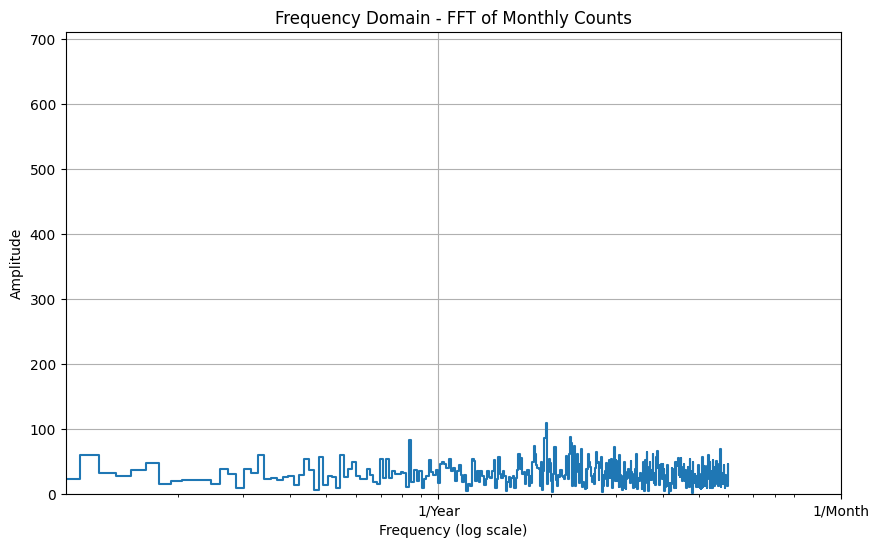

In [180]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'df' has a datetime column 'ds' and a value column 'y' (e.g., 'Tops')
# You already renamed 'release_month' → 'ds' and 'Tops' → 'y'

# Convert to numpy array
y = df['y'].values

# Apply real FFT
fft = tf.signal.rfft(y)

# Frequencies for FFT
f_per_dataset = np.arange(0, len(fft))

# Since this is monthly data:
n_samples = len(df['y'])
months_per_year = 12
years_per_dataset = n_samples / months_per_year

# Calculate frequency in cycles per year
f_per_year = f_per_dataset / years_per_dataset

# Plot the FFT
plt.figure(figsize=(10, 6))
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, max(np.abs(fft)) * 1.1)
plt.xlim([0.1, max(f_per_year)])
plt.xticks([1, 12], labels=['1/Year', '1/Month'])
plt.xlabel('Frequency (log scale)')
plt.ylabel('Amplitude')
plt.title('Frequency Domain - FFT of Monthly Counts')
plt.grid(True)
plt.show()


In [181]:
# Get magnitude of each frequency
amplitudes = np.abs(fft)

# Find the top peak (excluding the zero frequency which represents the mean)
dominant_freq_idx = np.argmax(amplitudes[1:]) + 1
dominant_frequency = f_per_year[dominant_freq_idx]
seasonality_period_months = 12 / dominant_frequency

print(f"Dominant frequency: {dominant_frequency:.2f} cycles/year")
print(f"Estimated seasonality period: {seasonality_period_months:.2f} months")


Dominant frequency: 1.95 cycles/year
Estimated seasonality period: 6.15 months


In [182]:
df

,ds,y,month
0,2021-12-01,0.0,12
1,2021-12-02,0.0,12
2,2021-12-03,0.0,12
3,2021-12-05,0.0,12
4,2021-12-06,0.0,12
...,...,...,...
874,2024-12-05,0.0,12
875,2024-12-06,0.0,12
876,2024-12-07,0.0,12
877,2024-12-17,1.0,12


In [183]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'



# Assign season
df['season'] = df['month'].apply(get_season)


In [184]:
season_dummies = pd.get_dummies(df['season'])
df = pd.concat([df, season_dummies], axis=1)

In [185]:
df = df.drop('season', axis=1)

In [186]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.8)]
test_df = df[int(n*0.8):]

num_features = df.shape[1]

In [187]:
# from prophet import Prophet
# from sklearn.metrics import r2_score, mean_squared_error
# from itertools import product
# import numpy as np

# param_grid = {
#     'changepoint_prior_scale': [0.001, 0.01, 0.1],
#     'seasonality_prior_scale': [5, 10, 20],
#     'changepoint_range': [0.8, 0.9]
# }

# all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]
# results = []

# for params in all_params:
#     model = Prophet(
#         changepoint_prior_scale=params['changepoint_prior_scale'],
#         seasonality_prior_scale=params['seasonality_prior_scale'],
#         changepoint_range=params['changepoint_range'],
#         yearly_seasonality=True,
#         weekly_seasonality=False,
#         daily_seasonality=False
#     )

#     model.fit(train_df)
#     future = model.make_future_dataframe(periods=len(test_df), freq='D')
#     forecast = model.predict(future)

#     # Merge predicted and actual
#     pred = forecast[['ds', 'yhat']].set_index('ds').join(test_df.set_index('ds'))
#     pred = pred.dropna()

#     r2 = r2_score(pred['y'], pred['yhat'])
#     rmse = np.sqrt(mean_squared_error(pred['y'], pred['yhat']))

#     results.append({'params': params, 'r2': r2, 'rmse': rmse})

# # Find best
# best = max(results, key=lambda x: x['r2'])
# print(f"✅ Best Parameters: {best['params']}")
# print(f"📈 Best R²: {best['r2']:.4f}, RMSE: {best['rmse']:.2f}")


In [216]:

train_df['prev_y'] = train_df['y'].shift(7).fillna(0)  # 7-day lag
train_df['prev_y2'] = train_df['y'].shift(30).fillna(0)  # 30-day lag

train_df['increasing_week'] = (train_df['y'] > train_df['prev_y']).astype(int)
train_df['increasing_month'] = (train_df['y'] > train_df['prev_y2']).astype(int)

model = Prophet(
    changepoint_prior_scale=0.1,  # Try increasing from 0.01 to 0.1 or even 0.5
    seasonality_prior_scale=15,   # More freedom for seasonal curve
    changepoint_range=0.95,
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
)
# Add custom monthly seasonality
model.add_regressor('increasing_month')

model.add_regressor('increasing_week')
model.fit(train_df)


<ipython-input-216-5ac03a42905a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['prev_y'] = train_df['y'].shift(7).fillna(0)  # 7-day lag
<ipython-input-216-5ac03a42905a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['prev_y2'] = train_df['y'].shift(30).fillna(0)  # 30-day lag
<ipython-input-216-5ac03a42905a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [217]:
test_df['prev_y2'] = test_df['y'].shift(30).fillna(0)  # 30-day lag


<ipython-input-217-cc6add139bd2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['prev_y2'] = test_df['y'].shift(30).fillna(0)  # 30-day lag


In [219]:
test_df['increasing_month'] = (test_df['y'] > test_df['prev_y2']).astype(int)


<ipython-input-219-85d8db0e0f05>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['increasing_month'] = (test_df['y'] > test_df['prev_y2']).astype(int)


test_df['prev_y'] = test_df['y'].shift(7).fillna(0)  # 7-day lag
test_df['increasing_week'] = (test_df['y'] > test_df['prev_y']).astype(int)


In [220]:
test_fcst = model.predict(test_df)

test_fcst['yhat'] = test_fcst['yhat'].clip(lower=0)
test_fcst['yhat_lower'] = test_fcst['yhat_lower'].clip(lower=0)
test_fcst['yhat_upper'] = test_fcst['yhat_upper'].clip(lower=0)
test_fcst['yhat'] = test_fcst['yhat'].round()

In [192]:
test_df

,ds,y,month,Autumn,Spring,Summer,Winter,prev_y,increasing_week,is_oct_nov
703,2024-04-12,0.0,4,False,True,False,False,0.0,0,0
704,2024-04-15,0.0,4,False,True,False,False,0.0,0,0
705,2024-04-16,0.0,4,False,True,False,False,0.0,0,0
706,2024-04-17,6.0,4,False,True,False,False,0.0,1,0
707,2024-04-18,0.0,4,False,True,False,False,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...
874,2024-12-05,0.0,12,False,False,False,True,7.0,0,0
875,2024-12-06,0.0,12,False,False,False,True,2.0,0,0
876,2024-12-07,0.0,12,False,False,False,True,0.0,0,0
877,2024-12-17,1.0,12,False,False,False,True,0.0,1,0


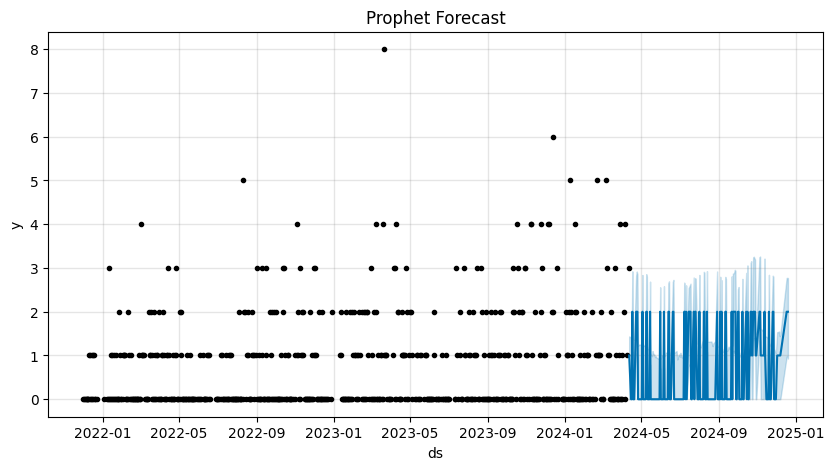

In [193]:


fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()



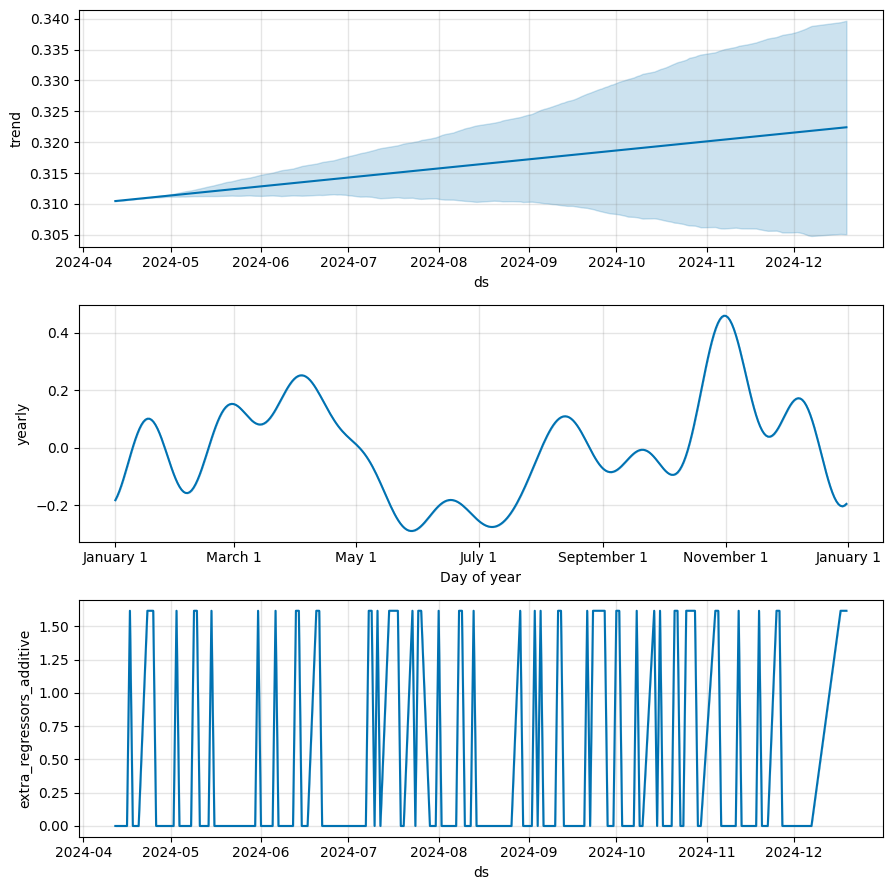

In [199]:

fig = model.plot_components(test_fcst)
plt.show()


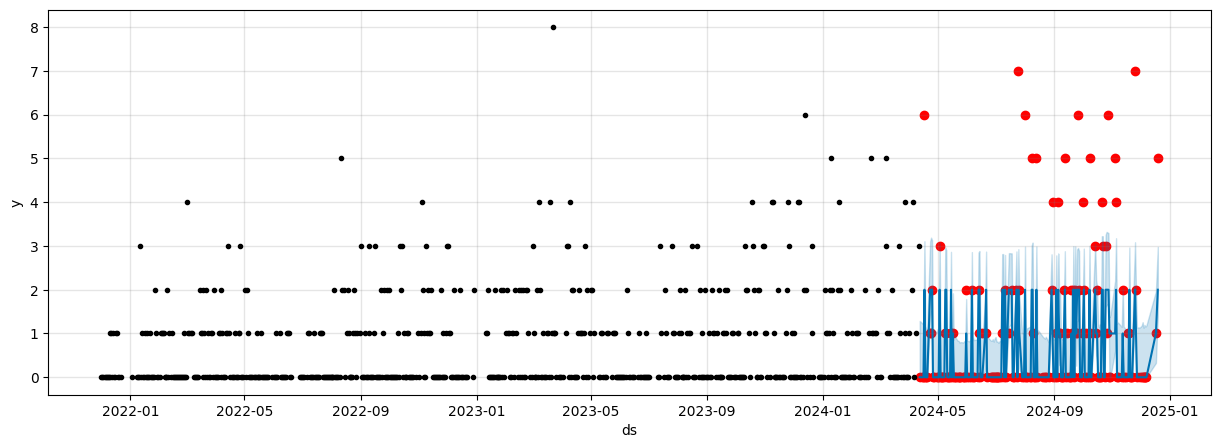

In [221]:


# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(test_df['ds'], test_df['y'], color='r')
fig = model.plot(test_fcst, ax=ax)



In [222]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Align predictions with actuals
y_true = test_df['y'].values
y_pred = test_fcst['yhat'].values

# Evaluation Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


MAE: 0.53
MSE: 1.37
RMSE: 1.17
R² Score: 0.47
